# Libraries

In [69]:
# Standard library imports
import os
import glob
import json
import random
import time as time
# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import IFrame

# SciPy imports
import scipy
from scipy.signal import square, butter, lfilter, spectrogram
import pandas as pd

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets
from torch.optim import lr_scheduler
import seaborn as sns

import torch.nn.functional as F
from torchvision import datasets, models
import timm  # For additional model architectures
from torchvision import models
from tqdm import tqdm


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import copy
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms.functional as TF
from collections import Counter


In [70]:
# Print versions of all imported libraries
libraries = {
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "PIL": Image.__version__,
    "scipy": scipy.__version__,
    "torch": torch.__version__,
    "scikit-learn": sklearn.__version__,
}

print("\nLibrary Versions:")
for lib, version in libraries.items():
    print(f"{lib}: {version}")


Library Versions:
numpy: 1.26.4
matplotlib: 3.10.1
PIL: 11.0.0
scipy: 1.15.2
torch: 2.6.0+cu126
scikit-learn: 1.6.1


# Seed

In [71]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# GPU Setup

In [72]:
print(f"Before clearing: {torch.cuda.memory_allocated()} bytes")
torch.cuda.empty_cache()
print(f"After clearing: {torch.cuda.memory_allocated()} bytes")


Before clearing: 3673569792 bytes
After clearing: 3673569792 bytes


In [73]:
# Device Configuration (Use GPU if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

torch.cuda.empty_cache()  # Clears unused memory
torch.cuda.memory_reserved(0)  # Forces clearing of reserved memory


print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("Releases unoccupied cached memory:",torch.cuda.empty_cache())  # Releases unoccupied cached memory
print("Resets max memory tracking:",torch.cuda.reset_max_memory_allocated())  # Resets max memory tracking
print("Shows reserved memory before reset:", torch.cuda.memory_reserved(0))  # Shows reserved memory before reset
print("SShows allocated memory before reset:", torch.cuda.memory_allocated(0))  # Shows allocated memory before reset


!nvidia-smi


Using device: cuda
CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 4090
Releases unoccupied cached memory: None
Resets max memory tracking: None
Shows reserved memory before reset: 4238344192
SShows allocated memory before reset: 3673569792
Tue Apr  8 18:24:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  | 

# Dataloader

In [74]:
class PolypSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        """
        Custom Dataset for Polyp Segmentation.

        Args:
            image_dir (str): Path to input images.
            mask_dir (str): Path to corresponding masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.files = self._load_files()

        # Embedded transform for both image and mask
        self.transform_image = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize image to 224x224
            transforms.ToTensor(),
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize mask to 224x224
            transforms.ToTensor(),
        ])

    def _load_files(self):
        """Loads image-mask file pairs based on filename matching."""
        files = []
        for fname in os.listdir(self.image_dir):
            if fname.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(self.image_dir, fname)
                mask_path = os.path.join(self.mask_dir, fname)
                if os.path.exists(mask_path):  # only if mask exists
                    files.append((img_path, mask_path))
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, mask_path = self.files[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.transform_image(img)
        mask = self.transform_mask(mask)
        mask = (mask > 0.5).float()  # Ensure binary

        return img, mask


In [75]:
# Train paths
dataset_name = "1.Kvasir-SEG"
train_image_dir = "./data/1.Kvasir-SEG/train/images"
train_mask_dir = "./data/1.Kvasir-SEG/train/masks"

# Validation paths
val_image_dir = "./data/1.Kvasir-SEG/validation/images"
val_mask_dir = "./data/1.Kvasir-SEG/validation/masks"

# Datasets
train_dataset = PolypSegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir)
val_dataset = PolypSegmentationDataset(image_dir=val_image_dir, mask_dir=val_mask_dir)



In [76]:
# dataset_name = "2.HyperKvasir"
# image_dir = "./data/2.HyperKvasir/images"
# mask_dir = "./data/2.HyperKvasir/masks"

# dataset = PolypSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir)

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



Total train samples: 800
Total validation samples: 100
Batch shape: torch.Size([4, 3, 224, 224])
Labels in one batch: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ...

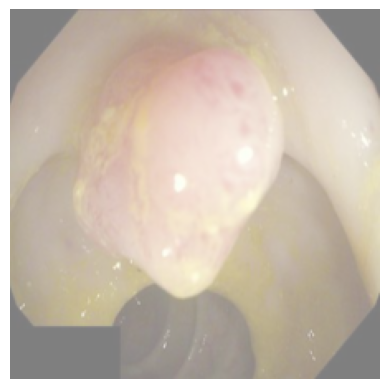

In [77]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# print("Total samples in dataset:", len(dataset))
print("Total train samples:", len(train_dataset))
print("Total validation samples:", len(val_dataset))
# print(f"One hot encoding to class: 0 → LTE Only, 1 → LTE + DSSS")
# print("Class distribution in Train Dataset:", train_class_counts)
# print("Class distribution in Validation Dataset:", val_class_counts)


# Check one batch and one sample
for images, labels in train_loader:
    print("Batch shape:", images.shape)  # Expected: (4, C, 400, 600) where C = 3 for RGB
    print("Labels in one batch:", labels)  # One-hot encoded labels

    print("One sample from batch")
    img = images[0]
    # Denormalize: (image * std) + mean
    img = img * 0.5 + 0.5  # Undo normalization from [-1,1] to [0,1]
    img = img.numpy()  # Convert to NumPy
    img = np.transpose(img, (1, 2, 0))  # Rearrange dimensions (C, H, W) → (H, W, C)
    
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    
    break

# Models

## UNet

In [78]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [79]:
unet = UNet(3, 1)

## Swin

In [80]:
class SwinSegmentationModel(nn.Module):
    def __init__(self, num_classes=1):  # Binary segmentation (polyp/no-polyp)
        super(SwinSegmentationModel, self).__init__()
        
        # Load a pre-trained Swin Transformer model
        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)

        # The output of the features_only model is a list of feature maps
        self.segmentation_head = nn.Conv2d(1024, num_classes, kernel_size=1)

        # Upsampling layer to match the original input size (224x224)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Get the features from the Swin Transformer
        features = self.swin(x)

        # Extract the last feature map (it should have shape [batch_size, 1024, H, W])
        last_feature_map = features[-1]  # Access the last feature map

        # Convert from HWC (Height, Width, Channels) to NCHW (Batch, Channels, Height, Width)
        last_feature_map = last_feature_map.permute(0, 3, 1, 2)

        # Apply the segmentation head (conv layer)
        out = self.segmentation_head(last_feature_map)
        
        # Upsample the output to the original image size (224x224)
        out = self.upsample(out)
        
        return out


In [81]:

swin = SwinSegmentationModel(1)

## CustomeSwin

In [82]:
class CustomeSwin(nn.Module):
    def __init__(self, backbone='swin_base_patch4_window7_224', pretrained=True, num_classes=1):
        super().__init__()

        # Swin Transformer backbone
        self.backbone = timm.create_model(
            backbone, pretrained=pretrained, features_only=True
        )
        self.encoder_channels = self.backbone.feature_info.channels()  # [128, 256, 512, 1024]

        # Decoder blocks with proper upsampling
        self.decoder4 = self.decoder_block(self.encoder_channels[3], 512)
        self.decoder3 = self.decoder_block(512 + self.encoder_channels[2], 256)
        self.decoder2 = self.decoder_block(256 + self.encoder_channels[1], 128)
        self.decoder1 = self.decoder_block(128 + self.encoder_channels[0], 64)

        # Final segmentation layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Changed to Upsample
        )

    def forward(self, x):
        # Extract features from the backbone
        feats = self.backbone(x)  # List of 4 feature maps
        # Ensure proper channel-first format
        feats = [f.permute(0, 3, 1, 2) if len(f.shape) == 4 and f.shape[1] > 4 else f for f in feats]
        f1, f2, f3, f4 = feats  # Correspond to different spatial resolutions

        # Decoder path with skip connections
        d4 = self.decoder4(f4)
        # Upsample d4 to match f3's spatial dimensions
        d4_up = F.interpolate(d4, size=f3.shape[2:], mode='bilinear', align_corners=True)
        d3 = self.decoder3(torch.cat([d4_up, f3], dim=1))
        
        # Upsample d3 to match f2's spatial dimensions
        d3_up = F.interpolate(d3, size=f2.shape[2:], mode='bilinear', align_corners=True)
        d2 = self.decoder2(torch.cat([d3_up, f2], dim=1))
        
        # Upsample d2 to match f1's spatial dimensions
        d2_up = F.interpolate(d2, size=f1.shape[2:], mode='bilinear', align_corners=True)
        d1 = self.decoder1(torch.cat([d2_up, f1], dim=1))

        # Final convolution to generate the output
        out = self.final_conv(d1)
        # Resize to input size if needed
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)

        return out

In [83]:
customeswin = CustomeSwin()

# Trainer

In [84]:
model_names = [unet,swin,customeswin]

In [85]:
# Ensure directories exist

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


os.makedirs(f"models/{dataset_name}/", exist_ok=True)
os.makedirs(f"logs/{dataset_name}/", exist_ok=True)

class Trainer:
    def __init__(self, model, train_loader, val_loader, epochs=10, lr=0.001, model_path="", log_path=""):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()  # Binary segmentation (polyp/no-polyp)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = StepLR(self.optimizer, step_size=3, gamma=0.1)
        self.writer = SummaryWriter(log_dir=log_path)
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_loss = float('inf')
        self.model_path = model_path

    def pixel_accuracy(self, outputs, masks):
        # Flatten the outputs and masks to 1D vectors
        outputs = torch.sigmoid(outputs).view(-1)
        masks = masks.view(-1)
        correct = (outputs.round() == masks).sum().item()
        total = masks.size(0)
        return correct / total

    def iou(self, outputs, masks):
        # Flatten the outputs and masks to 1D vectors
        outputs = torch.sigmoid(outputs).view(-1)
        masks = masks.view(-1)
        intersection = (outputs * masks).sum().item()
        union = outputs.sum().item() + masks.sum().item() - intersection
        return intersection / union if union != 0 else 0

    def dice_coefficient(self, outputs, masks):
        # Flatten the outputs and masks to 1D vectors
        outputs = torch.sigmoid(outputs).view(-1)
        masks = masks.view(-1)
        intersection = (outputs * masks).sum().item()
        return 2 * intersection / (outputs.sum().item() + masks.sum().item()) if (outputs.sum().item() + masks.sum().item()) != 0 else 0

    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_iou = 0.0
        running_dice = 0.0
        
        for batch_idx, (images, masks) in enumerate(self.train_loader):
            images, masks = images.to(device), masks.to(device)
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(images)

            # Loss calculation
            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            # Calculate metrics for the batch
            batch_acc = self.pixel_accuracy(outputs, masks)
            batch_iou = self.iou(outputs, masks)
            batch_dice = self.dice_coefficient(outputs, masks)

            running_acc += batch_acc
            running_iou += batch_iou
            running_dice += batch_dice

            # Log some images and loss
            if batch_idx == 0:  # Log only the first batch for efficiency
                self.writer.add_images('Train/Input_Images', images[:8], epoch)
                self.writer.add_graph(self.model, images)

        # Log the average loss and metrics for this epoch
        train_loss = running_loss / len(self.train_loader)
        train_acc = running_acc / len(self.train_loader)
        train_iou = running_iou / len(self.train_loader)
        train_dice = running_dice / len(self.train_loader)
        self.writer.add_scalar('Train/Loss', train_loss, epoch)
        self.writer.add_scalar('Train/Accuracy', train_acc, epoch)
        self.writer.add_scalar('Train/IoU', train_iou, epoch)
        self.writer.add_scalar('Train/Dice_Coefficient', train_dice, epoch)

        return train_loss, train_acc, train_iou, train_dice

    def validate_one_epoch(self, epoch):
        self.model.eval()
        val_running_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in self.val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = self.model(images)

                # Loss calculation
                loss = self.criterion(outputs, masks)
                val_running_loss += loss.item()

                # Calculate metrics
                val_acc += self.pixel_accuracy(outputs, masks)
                val_iou += self.iou(outputs, masks)
                val_dice += self.dice_coefficient(outputs, masks)

        # Log validation loss and metrics
        val_loss = val_running_loss / len(self.val_loader)
        val_acc = val_acc / len(self.val_loader)
        val_iou = val_iou / len(self.val_loader)
        val_dice = val_dice / len(self.val_loader)
        self.writer.add_scalar('Validation/Loss', val_loss, epoch)
        self.writer.add_scalar('Validation/Accuracy', val_acc, epoch)
        self.writer.add_scalar('Validation/IoU', val_iou, epoch)
        self.writer.add_scalar('Validation/Dice_Coefficient', val_dice, epoch)

        return val_loss, val_acc, val_iou, val_dice

    def train(self):
        for epoch in range(self.epochs):
            # Train for one epoch
            train_loss, train_acc, train_iou, train_dice = self.train_one_epoch(epoch)

            # Validate the model on the validation set
            val_loss, val_acc, val_iou, val_dice = self.validate_one_epoch(epoch)
            print(f"Epoch [{epoch+1}/{self.epochs}], Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train iou={train_iou:.4f}, Train dice={train_dice:.4f}, Val iou={val_iou:.4f}, Val dice={val_dice:.4f}")

            # Save the best model based on validation loss
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_model_wts = copy.deepcopy(self.model.state_dict())

            # Update learning rate scheduler
            self.scheduler.step()

        # Load the best model weights after training
        self.model.load_state_dict(self.best_model_wts)
        self.save_model()
        self.writer.close()

    def save_model(self):
        model_path = self.model_path
        torch.save(self.model.state_dict(), model_path)
        print(f"✅ Model saved at {model_path}")

In [86]:
for model in model_names:
    model_name =  model.__class__.__name__
    model_path = f"models/{dataset_name}/{model_name}.pth"
    log_path = f"logs/{dataset_name}/{model_name}/"

    if os.path.exists(model_path):
        print(f"\n🔄 {model_name} already trained and results exist. Skipping...")
        continue  # Skip training if model and results exist

    print(f"\n🚀 Training {model_name} from scratch...")
    # Initialize the trainer
    trainer = Trainer(model, train_loader, val_loader, epochs=50, lr=1e-4, model_path= model_path, log_path= log_path)
    
    # Start training
    trainer.train()


🔄 UNet already trained and results exist. Skipping...

🔄 SwinSegmentationModel already trained and results exist. Skipping...

🔄 CustomeSwin already trained and results exist. Skipping...


In [87]:
%load_ext tensorboard
%tensorboard --logdir ./logs/
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 35420), started 6:13:40 ago. (Use '!kill 35420' to kill it.)